In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [2]:
aapl_close = np.flip(np.array(yf.Ticker("AAPL").history(period="1y").Close))
amzn_close = np.flip(np.array(yf.Ticker("AMZN").history(period="1y").Close))
nke_close = np.flip(np.array(yf.Ticker("NKE").history(period="1y").Close))
mcd_close = np.flip(np.array(yf.Ticker("MCD").history(period="1y").Close))
koss_close = np.flip(np.array(yf.Ticker("KOSS").history(period="1y").Close))
ko_close = np.flip(np.array(yf.Ticker("KO").history(period="1y").Close))
pg_close = np.flip(np.array(yf.Ticker("PG").history(period="1y").Close))
eman_close = np.flip(np.array(yf.Ticker("EMAN").history(period="1y").Close))
ba_close = np.flip(np.array(yf.Ticker("BA").history(period="1y").Close))
msft_close = np.flip(np.array(yf.Ticker("MSFT").history(period="1y").Close))

data_close = np.array([aapl_close, amzn_close, nke_close, mcd_close, koss_close, ko_close, pg_close, eman_close, ba_close, msft_close])



### Profit and loss
Profit and loss for day t:
$$ p\&l(t) = \alpha(t)\left({P(t) \over P(t + 1)} - 1\right)$$
Cum profit and loss for day t:
$$ p\&l^{cum}(S) = \sum_{t = 0}^{S} p\&l(t)$$

In [3]:
def profit_and_loss(data, t, func_alpha):
    return sum((data[:,t] / data_close[:, t + 1] - 1) * func_alpha(data[:, t + 1:]))

In [4]:
def cum_profit_and_loss(data, start, func_alpha):
    answer = np.zeros(start)
    for i in range(start - 2, -1, -1):    
        answer[i] = answer[i + 1] + profit_and_loss(data, i, func_alpha)
    return answer[::-1]

In [5]:
def show_profit_and_loss(p_and_l_data):
    print('min:', min(p_and_l_data)) 
    print('max:', max(p_and_l_data))
    print('last value:', p_and_l_data[-1])
    plt.rcParams['font.size'] = '15'
    fig, ax = plt.subplots()
    plt.plot(np.linspace(0, len(p_and_l_data), len(p_and_l_data)), p_and_l_data)

    ax.grid(color = 'black',    #  цвет линий
                linewidth = 0.5,    #  толщина
                linestyle = '-')    #  начертание
    plt.legend(loc = 'best', fancybox = True, shadow = True)

    #plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))  # интервал написания значений оси OX
    plt.gca().yaxis.set_major_locator(ticker.MultipleLocator(0.01))  # интервал написания значений оси OY
    plt.xticks(rotation=25)

    fig.set_figwidth(15)
    fig.set_figheight(8)

    plt.title('Cumulative profit and loss')
    plt.show()

##### Alpha#1

$$ alpha1 = rank(TS\_ArgMax(SignedPower((returns < 0) ? stddev(returns, 20):close, 2.), 5)) - 0.5 $$

$$returns = {P(t) \over P(t + 1)} - 1$$ 
$$SignedPower(x, a) = x^{a}$$ 
standard deviation of the moving time series for the last d days: $$stddev(x, d)$$
time-series (TS). Vector of values by day for the stock: $$TS\_argmax(x, d)$$
the rank of the vector x: $$rank(x)$$
closing price: $$close$$

In [6]:
def f_returns(data_close, comp_id):
    return [data_close[comp_id][t] / data_close[comp_id][t + 1] - 1 for t in range(data_close.shape[1] - 1)]

In [7]:
def f_stddev(returns):
    return np.std(returns)

In [8]:
def kernel(data_close, comp_id):
    if data_close[comp_id][0] < data_close[comp_id][1]:
        return np.power(f_stddev(f_returns(data_close, comp_id)), 2)
    else:
        return np.power(data_close[comp_id][0], 2)

In [9]:
def ts_argmax(data_close, comp_id):
    ts = [kernel(np.lib.stride_tricks.sliding_window_view(data_close[comp_id], 20)[:5], i) for i in range(5)]
    return np.argmax(ts)

In [10]:
def alpha(data_close):
    rank = stats.rankdata([ts_argmax(data_close, i) for i in range(len(data_close))], method='ordinal') / len(data_close)
    alpha = (rank - np.mean(rank)) / sum(abs(rank - np.mean(rank)))
    return alpha

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


min: -0.04995016694733913
max: 0.15437753187817543
last value: 0.02325043810231958


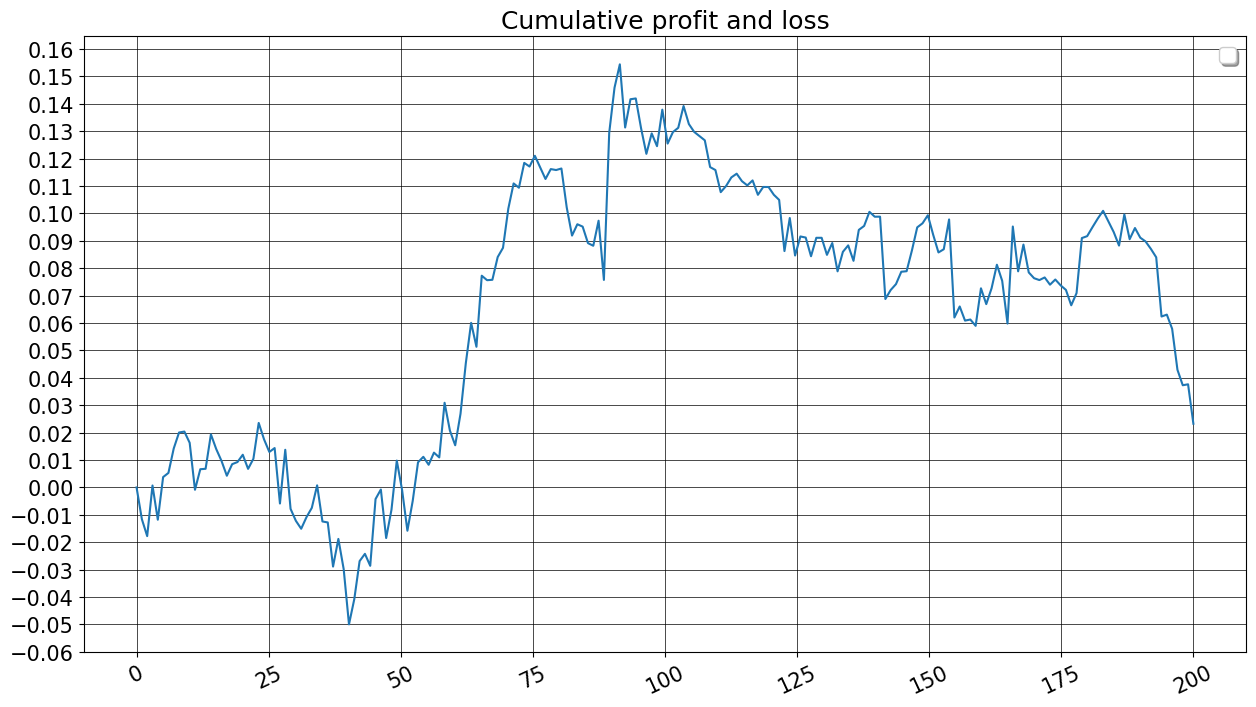

In [11]:
n = 200
show_profit_and_loss(cum_profit_and_loss(data_close, n, alpha))